In [25]:
# import
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt


from sklearn.datasets import fetch_mldata
from sklearn.linear_model import SGDClassifier

%matplotlib inline

In [7]:
mnist = fetch_mldata('MNIST original')

In [8]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [9]:
X, y = mnist['data'], mnist['target']

In [11]:
print(X.shape, y.shape)

(70000, 784) (70000,)


#### display an image

In [ ]:
some_digits = X[36001]
some_digits_img = some_digits.reshape(28, 28)

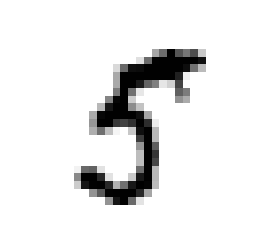

In [20]:
plt.imshow(some_digits_img, cmap=matplotlib.cm.binary, interpolation='Nearest')
plt.axis("off")
plt.show()

In [21]:
### checking out its label
y[36001]

5.0

In [23]:
# MNIST dataset is already split into train(first 60000) and test(last 10000) 
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

# let's suffle these train set to avoid any bias for algo
suffled_indices = np.random.permutation(60000)
X_train, y_train = X_train[suffled_indices], y_train[suffled_indices]

### Let's try to train a BINARY classification

In [29]:
# converting the target into binary info, Foy 5
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

 A good place to start is with a Stochastic Gradient Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class. This classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning)

In [30]:
sgd_clf = SGDClassifier(random_state=142)
sgd_clf.fit(X_train, y_train_5)

C:\tools\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=142, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [32]:
sgd_clf.predict([some_digits])

array([ True], dtype=bool)

### Measuring the Accuracy  
1. By Stratified Splitted data

In [33]:
from sklearn.model_selection import StratifiedShuffleSplit

In [38]:
skfolds = StratifiedShuffleSplit(n_splits=5, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    # creating classified object
    clone_clf = SGDClassifier(random_state=42)
    # splitting the data into train n test
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    # fitting the data
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    
    print(np.mean(y_pred==y_test_folds), end='   ')

C:\tools\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.9645   0.964666666667   0.879166666667   0.956833333333   0.885666666667   

2. Now using CV

In [39]:
from sklearn.model_selection import cross_val_score

In [41]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=5, scoring="accuracy")

array([ 0.95892009,  0.95125   ,  0.96066667,  0.91483333,  0.96541378])

As we can see accuract is above 90% in all cases, it seems weird, let's check the base estimate

In [42]:
from sklearn.base import BaseEstimator

In [43]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [45]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=5, scoring="accuracy")

array([ 0.90833333,  0.91083333,  0.91383333,  0.90833333,  0.90691667])

base classifier gives 90% accuracy bacause our data is skewed towards "Not 5" category

In [48]:
# being a image is 5 accuracy
print(np.mean(y_train_5))  # which means not 5 is
print(1-np.mean(y_train_5))

0.09035
0.90965


### Confusion Matrix

In [50]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_pred_5 = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5)
confusion_matrix(y_train_5, y_pred_5)

array([[52916,  1663],
       [ 1324,  4097]], dtype=int64)

### Precision and Recall  

$ precision = \frac{TP}{TP+FP} $  
$ recall = \frac{TP}{TP+FN} $

In [52]:
from sklearn.metrics import precision_score, recall_score

print("precision score: ", precision_score(y_train_5, y_pred_5))
print("recall score: ", recall_score(y_train_5, y_pred_5))

precision score:  0.711284722222
recall score:  0.755764619074
